Import required libraires

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

Retrieve Data

In [ ]:
# Current weights (can later load fromdfg CSV if needed)
current_weights = {
    "XLK": 0.2934, "XLF": 0.1463, "XLV": 0.1103, "XLY": 0.1017,
    "XLC": 0.0923, "XLI": 0.0861, "XLP": 0.0657, "XLE": 0.0339,
    "XLU": 0.0266, "XLRE": 0.0233, "XLB": 0.0204,
}

In [3]:
#Quarterly returns for each ETF
tickers = list(current_weights.keys())
start_date = "2018-01-01"

# Download adjusted close prices
data = yf.download(tickers, start=start_date)["Close"]
quarterly_returns = data.resample("QE").ffill().pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


In [4]:
# Calculate ETF Betas with respect to SPY
def calculate_beta(etf_returns, market_returns):
    betas = {}
    for col in etf_returns.columns:
        X = sm.add_constant(market_returns)
        y = etf_returns[col]
        model = sm.OLS(y, X).fit()
        betas[col] = model.params.iloc[1]  # Beta coefficient
    return betas

spy = yf.download("SPY", start=start_date)["Close"].resample("QE").ffill().pct_change().dropna()

aligned_returns = quarterly_returns.join(spy["SPY"], how="inner").dropna()
market_returns = aligned_returns["SPY"]
etf_only_returns = aligned_returns.drop(columns="SPY")

betas = calculate_beta(etf_only_returns, market_returns)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Fetch risk-free rate (10-year treasury yield)
tnx = yf.Ticker("^TNX")
rf_annual = tnx.history(period="1d")["Close"].iloc[-1] / 100  # Convert to decimal

In [6]:
# Equity Risk Premium (manual input for now)
erp_annual = float(0.0433)

Covariance Matrix calculations & Optimized weights

In [7]:
# Covariance Matrix
cov_matrix = quarterly_returns[tickers].cov().values

In [8]:
# Portfolio Optimization
def optimize_portfolio_weights(tickers, cov_matrix, current_weights, rf_annual, erp_annual, betas, rebalancing_tolerance=0.05):
    w0 = np.array([current_weights[t] for t in tickers])
    rf_q = rf_annual / 4
    erp_q = erp_annual / 4
    mu = np.array([rf_q + betas[t] * erp_q for t in tickers])

    bounds = [(max(0, w - rebalancing_tolerance), min(1, w + rebalancing_tolerance)) for w in w0]

    def neg_sharpe(w, mu, cov, rf):
        port_return = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -(port_return - rf) / port_vol

    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(neg_sharpe, w0, args=(mu, cov_matrix, rf_q), method='SLSQP', bounds=bounds, constraints=constraints)

    optimized = pd.Series(result.x, index=tickers)
    current = pd.Series(current_weights)
    comparison = pd.DataFrame({
        "Current Weight": current,
        "Optimized Weight": optimized,
        "Difference": optimized - current
    })
    return optimized, comparison, mu, cov_matrix


opt_weights, comparison_df, expected_return, cov_matrix = optimize_portfolio_weights(
    tickers, cov_matrix, current_weights, rf_annual, erp_annual, betas
)

print("\nWeight Comparison:")
print(comparison_df.map(lambda x: f"{x:.2%}"))


Weight Comparison:
     Current Weight Optimized Weight Difference
XLK          29.34%           34.34%      5.00%
XLF          14.63%           18.83%      4.20%
XLV          11.03%           11.64%      0.61%
XLY          10.17%           10.76%      0.59%
XLC           9.23%            4.74%     -4.49%
XLI           8.61%            7.02%     -1.59%
XLP           6.57%            6.96%      0.39%
XLE           3.39%            2.03%     -1.36%
XLU           2.66%            3.67%      1.01%
XLRE          2.33%            0.00%     -2.33%
XLB           2.04%            0.00%     -2.04%


Displaying finding

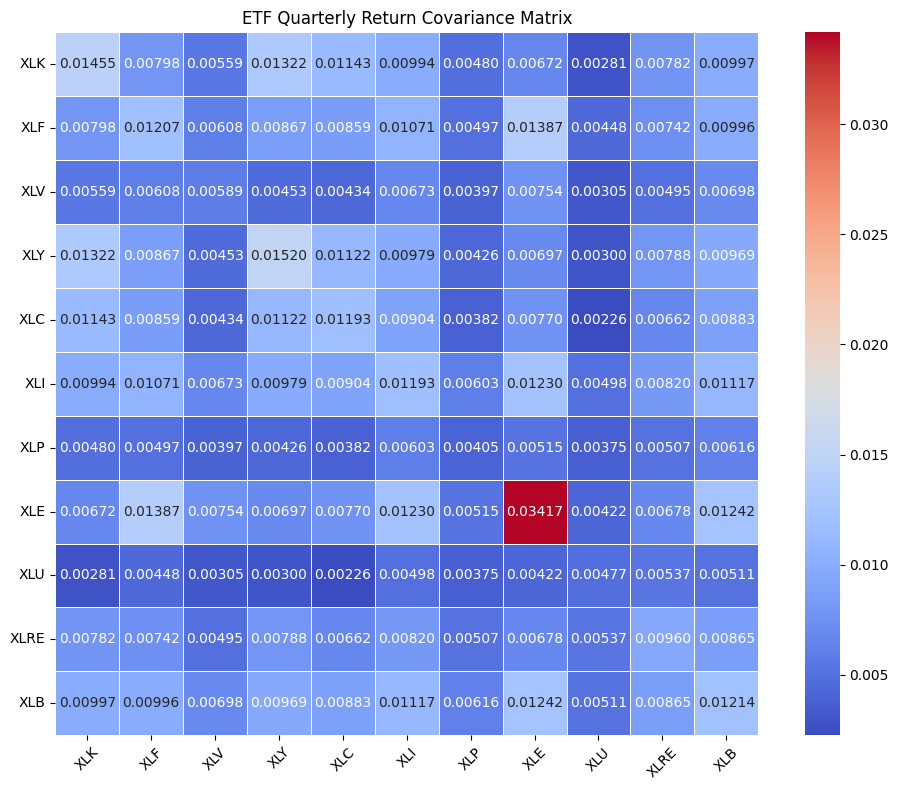

In [9]:
# Covariance Matrix Heatmap
cov_df = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
plt.figure(figsize=(10, 8))
sns.heatmap(cov_df, annot=True, fmt=".5f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("ETF Quarterly Return Covariance Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

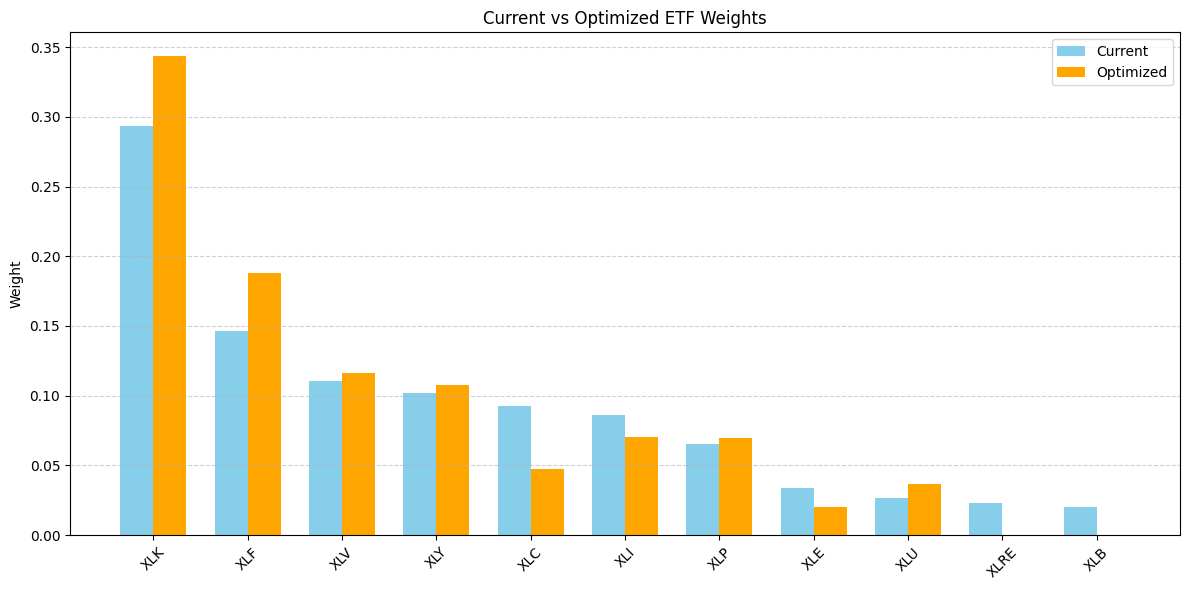

In [10]:
# Bar Plot: Current vs Optimized Weights
x = np.arange(len(tickers))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, comparison_df['Current Weight'], width, label='Current', color='skyblue')
ax.bar(x + width/2, comparison_df['Optimized Weight'], width, label='Optimized', color='orange')
ax.set_ylabel('Weight')
ax.set_title('Current vs Optimized ETF Weights')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [23]:
quarterly_returns.index[-5:]

DatetimeIndex(['2024-06-30', '2024-09-30', '2024-12-31', '2025-03-31',
               '2025-06-30'],
              dtype='datetime64[ns]', name='Date', freq='QE-DEC')

In [16]:
initial_investment = 10000
quarters = quarterly_returns.index[-5:]  # 5 points = 4 periods
portfolio_values = [initial_investment]
weights_history = []

current_value = initial_investment

for i in range(4):
    start_q = quarters[i]
    end_q = quarters[i + 1]
    
    # Slice returns up to the current quarter to estimate covariance and beta
    historical_returns = quarterly_returns.loc[:start_q]
    cov_matrix = historical_returns[tickers].cov().values

    # Align SPY returns and ETF returns
    spy_returns = spy.loc[:start_q]
    aligned_returns = historical_returns.join(spy_returns["SPY"], how="inner").dropna()
    market_returns = aligned_returns["SPY"]
    etf_only_returns = aligned_returns.drop(columns="SPY")
    
    # Recalculate beta using historical data up to the current quarter
    betas = calculate_beta(etf_only_returns, market_returns)
    
    # Optimize portfolio
    opt_weights, _, _, _ = optimize_portfolio_weights(
        tickers, cov_matrix, current_weights, rf_annual, erp_annual, betas
    )
    
    weights_history.append(opt_weights)
    
    # Apply returns for this quarter using optimized weights
    quarter_return = np.dot(quarterly_returns.loc[end_q], opt_weights)
    current_value *= (1 + quarter_return)
    portfolio_values.append(current_value)
    
    # Update weights for the next quarter
    current_weights = opt_weights.to_dict()

# Build result DataFrame
performance_df = pd.DataFrame({
    "Quarter End": quarters,
    "Portfolio Value": portfolio_values
})
performance_df["Return %"] = performance_df["Portfolio Value"].pct_change().fillna(0) * 100

In [26]:
performance_df

,Quarter End,Portfolio Value,Return %
0,2024-06-30,10000.000000,0.000000
1,2024-09-30,10750.463821,7.504638
2,2024-12-31,10421.015845,-3.064500
3,2025-03-31,10707.000155,2.744304
4,2025-06-30,10566.495395,-1.312270


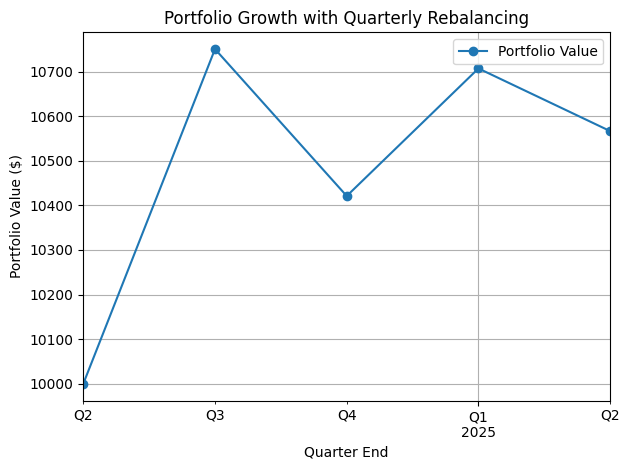

In [17]:
performance_df.plot(x="Quarter End", y="Portfolio Value", marker='o', title="Portfolio Growth with Quarterly Rebalancing")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()